In [1]:
from typing import List, Optional, Literal, Annotated
from typing_extensions import TypedDict
from langchain_core.language_models.chat_models import BaseChatModel
from langchain_core.messages import HumanMessage, trim_messages
from langchain_ollama import ChatOllama
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages

import re
import pandas as pd

# Initialize LLM
llm = ChatOllama(model="llama3.2:3b")

In [2]:
class TranscriptProcessor:
    """處理音轉文本和摘要生成的主要類"""
    def __init__(self, llm):
        self.llm = llm
        self.text_splitter = RecursiveCharacterTextSplitter(
            chunk_size=2000,
            chunk_overlap=200
        )

    def preprocess_text(self, text: str) -> str:
        """預處理文本，移除冗餘內容並保留關鍵資訊"""
        # 移除特殊符號和多餘空白
        text = re.sub(r'[\n\t]+', ' ', text)
        text = re.sub(r'\s+', ' ', text) 
        text = text.strip()

        # 移除常見的贅字贅語
        removals = [
            '請不吝點贊 訂閱 轉發 打賞支持明鏡與點點欄目',
            '我們就明天早上8點半早晨財經速解讀再相見',
            '祝各位投資朋友看盤順利操盤愉快'
        ]
        for r in removals:
            text = text.replace(r, '')

        return text

    def split_segments(self, text: str) -> List[str]:
        """將文本分割成較小的片段"""
        return self.text_splitter.split_text(text)

    def generate_summary(self, segments: List[str]) -> str:
        """基於文本片段生成摘要"""
        summaries = []
        for seg in segments:
            prompt = f"請總結以下文字段落的重點:\n{seg}"
            msg = HumanMessage(content=prompt)
            response = self.llm.invoke([msg])
            summaries.append(response.content)

        # 合併並產生最終摘要
        final_prompt = f"請整合以下重點並產生300字以內的摘要:\n{'\n'.join(summaries)}"
        final_msg = HumanMessage(content=final_prompt)
        final_summary = self.llm.invoke([final_msg])

        return final_summary.content

In [3]:
class State(TypedDict):
    messages: Annotated[list, add_messages]  # 儲存對話訊息
    transcript: str  # 儲存原始文本
    processed_text: str  # 儲存預處理後的文本
    segments: List[str]  # 儲存分段後的文本
    summary: str  # 儲存最終摘要

processor = TranscriptProcessor(llm)

def preprocess(state: State):
    """預處理文本節點"""
    text = state['transcript']
    processed = processor.preprocess_text(text)
    return {"processed_text": processed}

def split_text(state: State):
    """分割文本節點"""
    text = state['processed_text']
    segments = processor.split_segments(text)
    return {"segments": segments}

def summarize(state: State):
    """生成摘要節點"""
    segments = state['segments']
    summary = processor.generate_summary(segments)
    return {"summary": summary, "messages": [HumanMessage(content=summary)]}

# 建立工作流程圖
graph_builder = StateGraph(State)

# 添加節點
graph_builder.add_node("preprocess", preprocess)
graph_builder.add_node("split", split_text) 
graph_builder.add_node("summarize", summarize)

# 設定節點關係
graph_builder.add_edge(START, "preprocess")
graph_builder.add_edge("preprocess", "split")
graph_builder.add_edge("split", "summarize")
graph_builder.add_edge("summarize", END)

# 編譯工作流程
chain = graph_builder.compile()

In [4]:
# 讀取 CSV 檔案
df = pd.read_csv('../transcripts_video_v1.1.csv')

# 處理第一個逐字稿作為示例
sample_transcript = df['transcript'].iloc[0]

# 執行工作流程
result = chain.invoke({
    "transcript": sample_transcript,
    "messages": [],
    "processed_text": "",
    "segments": [],
    "summary": ""
})

print("\n最終摘要:")
print("-" * 50)
print(result["summary"])


最終摘要:
--------------------------------------------------
根據提供的重點，我們可以合整後產生以下300字的摘要：

美中關稅戰導致美國股市面臨波動和流動性恐慌，這對於美國股市來說是一個挑戰，需要觀察和留意。美國針對中國的關稅已經高達145%，川普總統在受訪中表示有持續調升的空間。

美股面臨的其他挑戰包括金融壓力指數（FSI）逼近22年熊市的最尾段、美國公債遭受顯著的暴跌和市場籌碼進行大量清洗。然而，美國對全球進口3.2兆美元貨物的關稅收集到3200億美元，目前仍在跟美國打關稅戰的基本上只剩下中國市場了。

美中關稅戰導致臺灣的經濟數據非常漂亮。臺廠供應鏈在東南亞市場非常重要，因為有可能會增長。臺積電池的營收表現很好，預估持續保持高強度的增長。

美國政府效率部裁員的現象可能會導致短期內失業救濟金申請人數增加，但這不一定會對經濟整體產生持久性影響。盛頓DC認為美國股市對於短期內的外部性衝擊較敏感，而長期來看，美國股市仍然預示出相當亮麗的數據和趨勢。

總之，美中關稅戰對於市場產生了顯著的影響，但臺灣的經濟數據會非常漂亮。投資朋友需要多做一些思考和觀察，使用數據進行佐證，以獲得更全面的市場理解。


Text Processing Workflow:


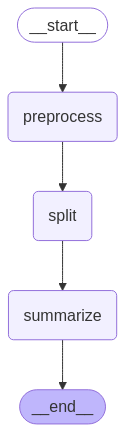

In [5]:
# Visualize the workflow graph
from IPython.display import Image, display

# First show the text processing workflow
print("Text Processing Workflow:")
try:
    display(Image(chain.get_graph().draw_mermaid_png()))
except Exception as e:
    print(f"Error displaying text processing graph: {e}")
    print("Text Processing structure:")
    print("START -> preprocess -> split -> summarize -> END")



In [6]:
"""
基於 ReAct 模式的核心工作流程：

analyze (分析) -> think (思考) -> decide (決策)
允許在 think 階段進行多輪思考-行動循環
智能決策機制：

每個思考步驟都會產生一個 ThoughtProcess 對象，記錄思考內容和行動
agent 可以根據需要自主決定是否調用外部工具獲取更多資訊
支援三種資料獲取行動：價格(price)、成交量(volume)和技術指標(technical)
彈性的工具調用：

使用 yfinance 獲取實時市場數據
使用 ta-lib 計算技術指標如 RSI、MACD
所有工具調用結果都會被加入到 context 中供後續決策參考
持續學習和推理：

agent 會記錄所有的思考過程和觀察結果
每個決策都是基於累積的資訊和多輪思考
"""

from typing import List, Dict, Any, Tuple, Optional, TypedDict
from enum import Enum
from dataclasses import dataclass
import json
from langchain_core.messages import HumanMessage
from langchain_ollama import ChatOllama
from langgraph.graph import StateGraph, END, START
import yfinance as yf
import pandas as pd
import ta

class MarketSentiment(Enum):
    BULLISH = "bullish"
    BEARISH = "bearish"
    NEUTRAL = "neutral"

@dataclass
class ThoughtProcess:
    thought: str
    action: Optional[str] = None
    action_input: Optional[Dict] = None
    observation: Optional[str] = None

class MarketState(TypedDict):
    summary: str  # 文本摘要
    sentiment: MarketSentiment  # 市場情緒
    thoughts: List[ThoughtProcess]  # 思考過程記錄
    decisions: List[str]  # 決策記錄
    context: Dict[str, Any]  # 額外的市場數據

class ReActMarketAgent:
    def __init__(self, model_name: str = "deepseek-r1:32b"):
        self.llm = ChatOllama(model=model_name)
        self.chain = self._build_chain()
        
    def _build_chain(self) -> StateGraph:
        """建立 ReAct 工作流程"""
        workflow = StateGraph(MarketState)
        
        # 添加節點
        workflow.add_node("analyze", self._analyze_content)
        workflow.add_node("think", self._think)
        workflow.add_node("decide", self._make_decision)
        
        # 設定工作流程
        workflow.add_edge(START, "analyze")
        workflow.add_edge("analyze", "think")
        workflow.add_edge("think", "decide")
        workflow.add_edge("decide", END)
        
        # 允許思考-行動循環
        workflow.add_edge("think", "think")
        
        return workflow.compile()

    def _analyze_content(self, state: MarketState) -> Dict:
        """分析摘要內容，評估市場情緒"""
        prompt = f"""請分析以下市場摘要，判斷市場情緒（看多/看空/中性）並提供理由：
        
        {state['summary']}
        
        請以下列格式回答：
        {{
            "sentiment": "BULLISH/BEARISH/NEUTRAL",
            "reasoning": "your analysis here"
        }}
        
        你必須使用以上確切的JSON格式回答，不要加入任何其他文字。
        """
        
        try:
            response = self.llm.invoke([HumanMessage(content=prompt)])
            # Clean the response content to ensure it only contains the JSON part
            content = response.content.strip()
            # Remove any markdown code block markers if present
            if content.startswith("```json"):
                content = content[7:]
            if content.startswith("```"):
                content = content[3:]
            if content.endswith("```"):
                content = content[:-3]
            content = content.strip()
            
            analysis = json.loads(content)
            
            # Validate required fields
            if "sentiment" not in analysis or "reasoning" not in analysis:
                raise ValueError("Missing required fields in response")
                
            # Default to NEUTRAL if sentiment is invalid
            try:
                sentiment = MarketSentiment(analysis["sentiment"].lower())
            except ValueError:
                sentiment = MarketSentiment.NEUTRAL
                
            return {
                "sentiment": sentiment,
                "thoughts": [ThoughtProcess(
                    thought=f"Initial analysis: {analysis['reasoning']}"
                )]
            }
            
        except json.JSONDecodeError as e:
            # If JSON parsing fails, return a neutral sentiment with error info
            return {
                "sentiment": MarketSentiment.NEUTRAL,
                "thoughts": [ThoughtProcess(
                    thought=f"Error parsing market analysis. Defaulting to neutral sentiment. Error: {str(e)}"
                )]
            }
        except Exception as e:
            # Handle any other unexpected errors
            return {
                "sentiment": MarketSentiment.NEUTRAL,
                "thoughts": [ThoughtProcess(
                    thought=f"Unexpected error during analysis. Defaulting to neutral sentiment. Error: {str(e)}"
                )]
            }

    def _think(self, state: MarketState) -> Dict:
        """進行思考並決定是否需要額外資訊"""
        current_context = state["context"]
        last_thought = state["thoughts"][-1]
        
        prompt = f"""基於目前資訊：
        1. 市場情緒: {state['sentiment'].value}
        2. 上一個想法: {last_thought.thought}
        3. 已有的市場數據: {json.dumps(current_context, indent=2)}
        
        請思考是否需要額外資訊？如果需要，請說明需要什麼資訊。
        
        請以下列格式回答：
        {{
            "thought": "思考過程",
            "need_action": true/false,
            "action": "price/volume/technical",
            "symbols": ["股票代碼1", "股票代碼2"]
        }}
        
        你必須使用以上確切的JSON格式回答，不要加入任何其他文字。
        """
        
        try:
            response = self.llm.invoke([HumanMessage(content=prompt)])
            # Clean the response content
            content = response.content.strip()
            # Remove any markdown code block markers if present
            if content.startswith("```json"):
                content = content[7:]
            if content.startswith("```"):
                content = content[3:]
            if content.endswith("```"):
                content = content[:-3]
            content = content.strip()
            
            thinking = json.loads(content)
            
            # Validate required fields
            if "thought" not in thinking:
                raise ValueError("Missing required 'thought' field in response")
            if "need_action" not in thinking:
                raise ValueError("Missing required 'need_action' field in response")
                
            # Create new thought process
            new_thought = ThoughtProcess(
                thought=thinking["thought"],
                action=thinking.get("action") if thinking.get("need_action") else None,
                action_input={"symbols": thinking.get("symbols", [])} if thinking.get("need_action") else None
            )
            
            # If action is needed, validate action type
            if thinking.get("need_action"):
                if "action" not in thinking:
                    raise ValueError("Action required but 'action' field missing")
                if thinking["action"] not in ["price", "volume", "technical"]:
                    raise ValueError(f"Invalid action type: {thinking['action']}")
                if "symbols" not in thinking or not thinking["symbols"]:
                    raise ValueError("Action requires symbols but none provided")
                
                # Execute the appropriate action
                if thinking["action"] == "price":
                    data = self._fetch_price_data(thinking["symbols"])
                elif thinking["action"] == "technical":
                    data = self._fetch_technical_indicators(thinking["symbols"])
                else:  # volume
                    data = self._fetch_volume_data(thinking["symbols"])
                
                new_thought.observation = str(data)
                state["context"].update({thinking["action"]: data})
            
            return {
                "thoughts": state["thoughts"] + [new_thought]
            }
            
        except json.JSONDecodeError as e:
            # If JSON parsing fails, return a generic thought
            new_thought = ThoughtProcess(
                thought="Error parsing thinking process. Will proceed with available information.",
            )
            return {
                "thoughts": state["thoughts"] + [new_thought]
            }
        except Exception as e:
            # Handle any other unexpected errors
            new_thought = ThoughtProcess(
                thought=f"Unexpected error during thinking process: {str(e)}. Will proceed with available information.",
            )
            return {
                "thoughts": state["thoughts"] + [new_thought]
            }

    def _make_decision(self, state: MarketState) -> Dict:
        """基於所有資訊作出最終決策"""
        all_thoughts = "\n".join(f"- {t.thought}" for t in state["thoughts"])
        context_data = json.dumps(state["context"], indent=2)
        
        prompt = f"""基於以下資訊，請作出投資決策建議：
        
        市場情緒: {state['sentiment'].value}
        思考過程:
        {all_thoughts}
        
        市場數據:
        {context_data}
        
        請提供具體的投資建議，包含:
        1. 建議操作（買入/賣出/觀望）
        2. 目標標的
        3. 理由說明
        """
        
        response = self.llm.invoke([HumanMessage(content=prompt)])
        return {
            "decisions": state["decisions"] + [response.content]
        }

    def _fetch_price_data(self, symbols: List[str]) -> Dict:
        """獲取價格數據"""
        data = {}
        for symbol in symbols:
            try:
                stock = yf.Ticker(symbol)
                hist = stock.history(period="1mo")
                data[symbol] = {
                    "current": hist["Close"][-1],
                    "change": (hist["Close"][-1] - hist["Close"][0]) / hist["Close"][0]
                }
            except Exception as e:
                data[symbol] = {"error": str(e)}
        return data

    def _fetch_technical_indicators(self, symbols: List[str]) -> Dict:
        """獲取技術指標"""
        data = {}
        for symbol in symbols:
            try:
                stock = yf.Ticker(symbol)
                hist = stock.history(period="3mo")
                
                # 計算技術指標
                hist["RSI"] = ta.momentum.RSIIndicator(hist["Close"]).rsi()
                hist["MACD"] = ta.trend.MACD(hist["Close"]).macd()
                
                data[symbol] = {
                    "RSI": hist["RSI"][-1],
                    "MACD": hist["MACD"][-1]
                }
            except Exception as e:
                data[symbol] = {"error": str(e)}
        return data

    def _fetch_volume_data(self, symbols: List[str]) -> Dict:
        """獲取成交量數據"""
        data = {}
        for symbol in symbols:
            try:
                stock = yf.Ticker(symbol)
                hist = stock.history(period="1mo")
                data[symbol] = {
                    "avg_volume": hist["Volume"].mean(),
                    "volume_trend": (hist["Volume"][-5:].mean() / hist["Volume"][:-5].mean() - 1)
                }
            except Exception as e:
                data[symbol] = {"error": str(e)}
        return data

    def analyze_market(self, summary: str) -> Dict[str, Any]:
        """執行完整的市場分析流程"""
        initial_state = {
            "summary": summary,
            "sentiment": MarketSentiment.NEUTRAL,
            "thoughts": [],
            "decisions": [],
            "context": {}
        }
        
        return self.chain.invoke(initial_state)

# 使用範例
if __name__ == "__main__":
    agent = ReActMarketAgent()
    summary = """
    今日市場顯示多個看漲信號：
    1. 台積電ADR大漲7%
    2. 外資持續買超
    3. 美股科技股普遍走強
    然而需要注意以下風險：
    1. 美債殖利率持續上升
    2. 通膨數據仍高於預期
    """
    
    result = agent.analyze_market(summary)
    
    print("\n分析結果:")
    print("-" * 50)
    print(f"市場情緒: {result['sentiment'].value}")
    print("\n思考過程:")
    for thought in result["thoughts"]:
        print(f"- {thought.thought}")
        if thought.action:
            print(f"  行動: {thought.action}")
            print(f"  觀察: {thought.observation}")
    
    print("\n決策建議:")
    for decision in result["decisions"]:
        print(f"- {decision}")

GraphRecursionError: Recursion limit of 25 reached without hitting a stop condition. You can increase the limit by setting the `recursion_limit` config key.
For troubleshooting, visit: https://python.langchain.com/docs/troubleshooting/errors/GRAPH_RECURSION_LIMIT

In [7]:
# Create an instance of ReActMarketAgent
agent = ReActMarketAgent()

# example usage
from Agentic_AI.market_node import ReActMarketAgent

agent = ReActMarketAgent()
result = agent.analyze_market("""
    台積電今日營收報告優於預期，
    外資大舉買超超過50億，
    但需注意美國CPI數據即將公布
""")

ModuleNotFoundError: No module named 'Agentic_AI'


Market Analysis Workflow:


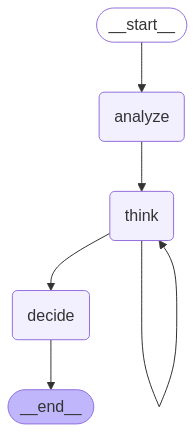

In [8]:
print("\nMarket Analysis Workflow:")
try:
    agent = ReActMarketAgent()
    display(Image(agent.chain.get_graph().draw_mermaid_png()))
except Exception as e:
    print(f"Error displaying market analysis graph: {e}")
    print("Market Analysis structure:")
    print("START -> analyze -> think -> decide -> END")
    print("(think can loop back to itself)")